In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import torch as th

from ethos.constants import ADMISSION_STOKEN, DISCHARGE_STOKEN, PROJECT_DATA
from ethos.tokenize import SpecialToken, Vocabulary
from ethos.utils import load_data

warnings.filterwarnings("ignore")

dataset_dir = PROJECT_DATA / "tokenized_datasets"

vocab = Vocabulary(dataset_dir / "mimic_vocab_t4367.pkl")
timeline_end_token = vocab.encode(SpecialToken.TIMELINE_END)
separator_tokens = th.from_numpy(vocab.encode(SpecialToken.SEPARATOR_NAMES).astype(np.int32))
f"Vocab size: {len(vocab):,}"

'Vocab size: 4,367'

In [3]:
dataset_path = dataset_dir / "mimic_test_timelines_p26758.hdf5"
data = load_data(dataset_path, n_tokens=None)
times, tokens, patient_context, *_ = data.values()
print(f"Test dataset tokens: {len(times):,}, patients: {len(patient_context):,}")

Test dataset tokens: 32,565,814, patients: 26,758


In [4]:
n_patient = len(patient_context)
p_ctx_df = pd.DataFrame(vocab.decode(patient_context.numpy().reshape(-1)).reshape(n_patient, -1))
p_ctx_df[0].value_counts(dropna=False)

0
SEX_F    14473
SEX_M    12285
Name: count, dtype: int64

In [5]:
token_df = pd.DataFrame(tokens.numpy())
token_df = token_df.value_counts(dropna=False, normalize=True).reset_index()
token_df[0] = vocab.decode(token_df[0])
token_df.rename({0: "token"}, inplace=True, axis=1)
token_df

,token,proportion
0,ATC_4_A,5.213691e-02
1,_Q1,4.816035e-02
2,_Q2,3.632561e-02
3,_Q3,3.615939e-02
4,_Q5,3.363853e-02
...,...,...
3723,ICD_4-5_837,3.070705e-08
3724,ICD_4-5_B21,3.070705e-08
3725,ICD_4-5_070,3.070705e-08
3726,ATC_SUFFIX_B35,3.070705e-08


In [6]:
black_color = "#404040ff"
gray_color = "#b2b2b2ff"
sns.set(style="white", font='Roboto', context="paper")
font_kwargs = dict(fontfamily='Roboto', fontsize=14, fontweight='bold', color=black_color)


def autolabel(ax):
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f"{width:.2%}", (p.get_x() + width, p.get_y() + p.get_height() / 2 + 0.05),
                    ha='left', va='center', xytext=(1, 0), textcoords='offset points',
                    **font_kwargs)

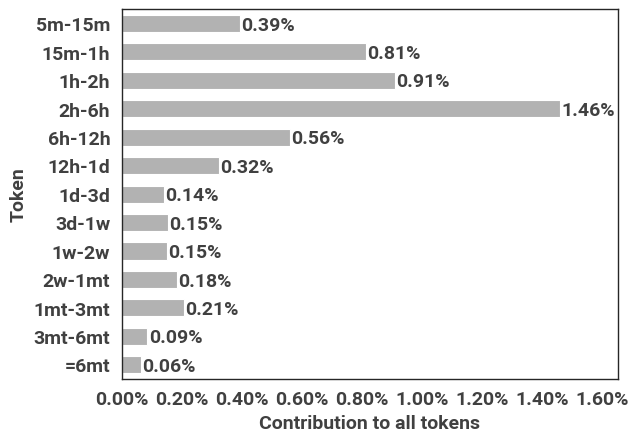

In [7]:
separator_freqs = token_df.loc[token_df.token.isin(SpecialToken.SEPARATOR_NAMES)]
ax = sns.barplot(data=separator_freqs, x="proportion", y="token",
                 order=SpecialToken.SEPARATOR_NAMES, color=gray_color,
                 width=0.6)

yticklabels = [t.get_text()[1:] for t in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels, **font_kwargs)
ax.set_xticklabels([f"{t:.2%}" for t in ax.get_xticks()], **font_kwargs)
ax.set_xlabel("Contribution to all tokens", **font_kwargs)
ax.set_ylabel("Token", **font_kwargs)
ax.set_xlim(0, .0165)
autolabel(ax)

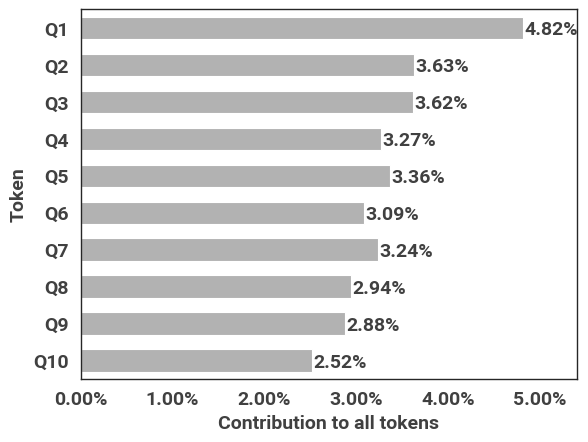

In [8]:
quantile_freqs = token_df.loc[token_df.token.isin(SpecialToken.DECILES)]
ax = sns.barplot(data=quantile_freqs, x="proportion", y="token",
                 order=SpecialToken.DECILES, color=gray_color,
                 width=0.6)

yticklabels = [t.get_text()[1:] for t in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels, **font_kwargs)
ax.set_xticklabels([f"{t:.2%}" for t in ax.get_xticks()], **font_kwargs)
ax.set_xlabel("Contribution to all tokens", **font_kwargs)
ax.set_ylabel("Token", **font_kwargs)
ax.set_xlim(0, .054)
autolabel(ax)

Text(0.5, 1.0, 'Non-special token frequencies')

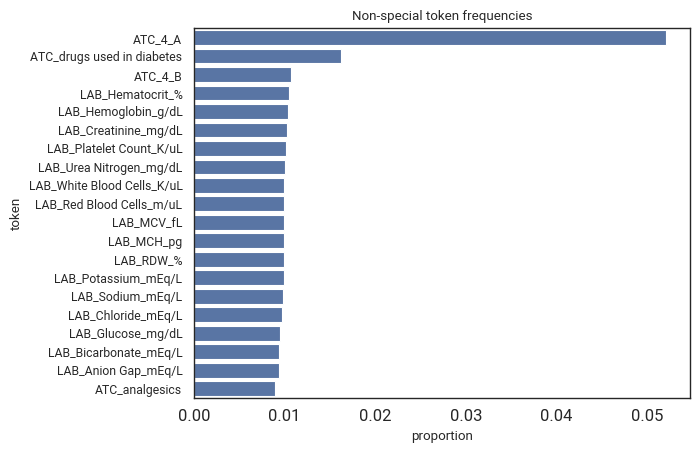

In [9]:
non_special_freqs_top20 = token_df.loc[~token_df.token.isin(SpecialToken.ALL)].head(20)
ax = sns.barplot(data=non_special_freqs_top20, y="token", x="proportion")
labels = ax.get_xticklabels()
for t in labels:
    t.set_text(t.get_text()[:15].lower())
ax.set_xticklabels(labels, rotation=0, fontsize=12)
ax.set_title("Non-special token frequencies")

In [10]:
separator_mask = th.isin(tokens, separator_tokens)
tokens_nosep = tokens[~separator_mask]
times_nosep = times[~separator_mask]
f"Tokens excluding separators: {len(times_nosep):,} ({len(times_nosep) / len(times):.2%})"

'Tokens excluding separators: 30,794,439 (94.56%)'

In [11]:
timeline_end_token = vocab.encode(SpecialToken.TIMELINE_END)
deltas = times_nosep[1:] - times_nosep[:-1]
deltas = deltas[tokens_nosep[:-1] != timeline_end_token]
deltas = deltas[deltas != 0]
f"Time deltas: {len(deltas):,}"

'Time deltas: 1,861,008'